<a href="https://colab.research.google.com/github/mikemanski/AudioMnist/blob/main/AudioMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Audio MNIST: Speech Classification ##

This notebook provides an example of processing the [Audio MNIST](https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist) dataset from Kaggle.
The dataset contains 30,000 total audio recordings of spoken digits (0-9) from 60 different speakers (500 recordings per speaker).

The experiments are organized in a K-folds manner (K=4), where splits are with respect to speakers (as opposed to individual samples).
This means there will be no overlap of speakers represented in the training & validation sets.

Like the original MNIST, the goal is classification, but now with spoken audio data.

In [1]:
### Take care of library installs (if needed)
# !pip install tensorflow
# !pip install seaborn
# !pip install scikit-learn
# !pip install librosa
# !pip install pandas

### Commands for downloading / unpacking the Kaggle dataset
!pip install kaggle
!mkdir ~/.kaggle
!echo \{\"username\":\"michaelwilmanski\",\"key\":\"2508bcfa774b189361a8c829ce285e7b\"\} > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download sripaadsrinivasan/audio-mnist
!unzip -q audio-mnist.zip

 98% 930M/948M [00:11<00:00, 131MB/s]
100% 948M/948M [00:11<00:00, 83.5MB/s]


In [2]:
### Library Imports
import librosa # Audio Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow.keras.layers as KLayers
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import tensorflow as tf
import seaborn
import os

## Preprocessing Audio: MFCC Representation ##

The preprocessing code below converts raw audio waveforms (.WAV) into Mel-frequency ceptral coefficients (MFCC) using the Librosa audio processing library. [MFCC](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) is conceptually similar to a [spectrogram](https://en.wikipedia.org/wiki/Spectrogram), but is more compact & the specific frequencies it samples are better tuned to human speech. Like a spectrogram, the output can be treated like a 2D image, where one dimension nominally represents frequency information while the other represents time-frames.

The MFCCs of the audio files would normally have a variable length time-frame dimension (13 to 44 frames), due to differing recording durations.
For efficient batch-processing, the MFCCs will have their time-frame dimension cropped/padded to size 40 (resulting in images of size 40x40x1).

The model employed is a small classifier CNN, which permits variable length along the time-frame dimension.  

In [3]:
### Functions to assist in loading / processing the data as Mel-frequency ceptra,
# & to define the model

# Helper function for padding or cropping axis 1 to the given target size
def padOrCropAx1(x, targetSize=40):
    dimSize = x.shape[1]

    if targetSize > dimSize: #then we must pad
        sizeDiff = targetSize-dimSize
        side1 = sizeDiff//2
        side2 = side1 + sizeDiff%2
        x = np.pad(x, pad_width=((0,0),(side1,side2)))
    elif targetSize < dimSize: #then we must crop
        sizeDiff = dimSize-targetSize
        side1 = sizeDiff//2
        side2 = side1 + sizeDiff%2
        x = x[:, side1:-side2]
    return x

def extractAudioFeatures(file, nFrames=40):
    audio, sample_rate = librosa.load(file) # Load audio and sample rate of audio
    extracted_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40) # Process as mel-frequency ceptral coefficients
    extracted_features_ = padOrCropAx1(extracted_features, targetSize=nFrames)
    return extracted_features_[..., None] # Return extracted features (add channel dim)

# Helper function, to assist in conversion between person-ID integer vs string represetnation
def createIdStrList(minId=1, maxId=60):
    idStrList = []
    for id in range(minId, maxId+1):
        idStr = str(id)
        if id < 10: idStr = '0'+idStr
        idStrList.append(idStr)
    return idStrList

# Function that extracts the data from audio files
def loadAudioMnistByPerson(dataRootDir='/data', verbose=True):
    datasetByPerson = []

    # Iterating through the person-folders, where each folder has audio of each digit
    personIdStrList = createIdStrList(minId=1, maxId=60)
    for personIdStr in personIdStrList:
        personSet = []
        if verbose: print("loading person id = " + personIdStr + " / " + personIdStrList[-1])
        personFolder = os.path.join(dataRootDir, personIdStr) #for OS-independent paths. It's ok to have trailing '/'

        # Iterate through each file of the present folder
        for fname in os.listdir(personFolder):
            fpath = os.path.join(personFolder, fname) # Path of the file
            extracted_features = extractAudioFeatures(fpath) # Create features, given path of audio file
            class_label = int(fname[0]) # Class of the audio file (i.e., digit it represents)
            class_label_ = tf.keras.utils.to_categorical(class_label, num_classes=10) # Convert to 1-hot encoding
            personSet.append([extracted_features, class_label_]) # Append list where features & class represent columns
        datasetByPerson.append(pd.DataFrame(personSet, columns=['features','class'])) # Convert the list to a dataframe

    return datasetByPerson

# Define model
def defineModel():
    renorm_clipping = {'rmin':0.9, 'rmax':1.1, 'dmax':0.1} # Using Batch Renormalization: arxiv.org/abs/1702.03275
    x0 = KLayers.Input((40,None,1)) # None size along time-frames dim is to accomodate potential variable # of frames

    x1a = KLayers.Conv2D(16, kernel_size=(5,5), padding='valid')(x0) # map size: [36 x 36]
    x1b = KLayers.BatchNormalization(renorm=True, renorm_clipping=renorm_clipping)(x1a)
    x1c = KLayers.Activation('relu')(x1b)
    x1d = KLayers.MaxPooling2D(pool_size=(4,3))(x1c) #[9 x 12]

    x2a = KLayers.Conv2D(32, kernel_size=(4,3), padding='valid')(x1d) #[6 x 10]
    x2b = KLayers.BatchNormalization(renorm=True, renorm_clipping=renorm_clipping)(x2a)
    x2c = KLayers.Activation('relu')(x2b)
    x2d = KLayers.MaxPooling2D(pool_size=(2,2))(x2c) # [3 x 5]

    x3a = KLayers.Conv2D(64, kernel_size=(3,3), padding='valid')(x2d) #[1 x 3]
    #feature maps are now too small, so skip batch-norm
    x3b = KLayers.Activation('relu')(x3a)
    x3c = KLayers.GlobalMaxPooling2D(keepdims=False)(x3b) # will also flatten shape

    x4 = KLayers.Dense(10, activation='softmax')(x3c)
    return Model(inputs=x0, outputs=x4)

In [4]:
### Load full dataset
mnist_byPersonId = loadAudioMnistByPerson(dataRootDir='data/', verbose=False)

## Determine what the folds will be (by personId)
personIds = np.arange(60) #0-based indexing here
nFolds = 4 #2

kf = KFold(n_splits=nFolds)
trnIds_byFold = []; tstIds_byFold = []
for (trnIds_, tstIds_) in kf.split(personIds):
    trnIds_byFold.append(trnIds_)
    tstIds_byFold.append(tstIds_)

Beginning Fold 1 / 4
Epoch 1/25
704/704 [==============================] - 22s 9ms/step - loss: 0.2095 - accuracy: 0.9464 - val_loss: 0.1499 - val_accuracy: 0.9488
Epoch 2/25
704/704 [==============================] - 5s 7ms/step - loss: 0.0132 - accuracy: 0.9967 - val_loss: 0.0323 - val_accuracy: 0.9897
Epoch 3/25
704/704 [==============================] - 6s 9ms/step - loss: 0.0092 - accuracy: 0.9976 - val_loss: 0.0704 - val_accuracy: 0.9748
Epoch 4/25
704/704 [==============================] - 5s 7ms/step - loss: 0.0071 - accuracy: 0.9978 - val_loss: 0.1713 - val_accuracy: 0.9528
Epoch 5/25
704/704 [==============================] - 6s 8ms/step - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.0636 - val_accuracy: 0.9816
Epoch 6/25
704/704 [==============================] - 5s 8ms/step - loss: 0.0085 - accuracy: 0.9974 - val_loss: 0.0392 - val_accuracy: 0.9868
Epoch 7/25
704/704 [==============================] - 7s 10ms/step - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.1090 - val_

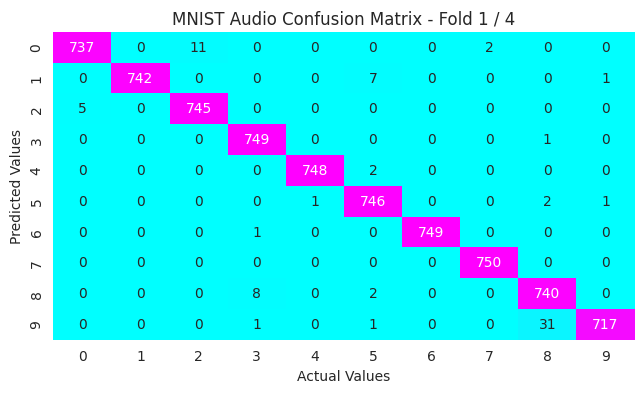

Beginning Fold 2 / 4
Epoch 1/25
704/704 [==============================] - 8s 8ms/step - loss: 0.2467 - accuracy: 0.9324 - val_loss: 0.0292 - val_accuracy: 0.9936
Epoch 2/25
704/704 [==============================] - 6s 8ms/step - loss: 0.0176 - accuracy: 0.9948 - val_loss: 0.0797 - val_accuracy: 0.9715
Epoch 3/25
704/704 [==============================] - 5s 7ms/step - loss: 0.0081 - accuracy: 0.9980 - val_loss: 0.0264 - val_accuracy: 0.9933
Epoch 4/25
704/704 [==============================] - 6s 8ms/step - loss: 0.0085 - accuracy: 0.9973 - val_loss: 0.0336 - val_accuracy: 0.9880
Epoch 5/25
704/704 [==============================] - 5s 7ms/step - loss: 0.0054 - accuracy: 0.9988 - val_loss: 0.0346 - val_accuracy: 0.9900
Epoch 6/25
704/704 [==============================] - 5s 8ms/step - loss: 0.0041 - accuracy: 0.9985 - val_loss: 0.0220 - val_accuracy: 0.9939
Epoch 7/25
704/704 [==============================] - 6s 8ms/step - loss: 0.0041 - accuracy: 0.9986 - val_loss: 0.0707 - val_ac

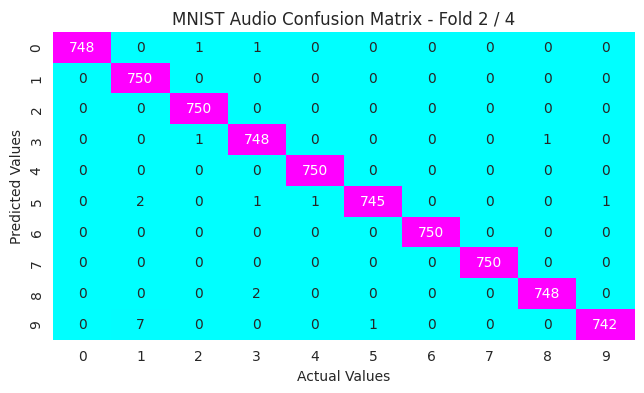

Beginning Fold 3 / 4
Epoch 1/25
704/704 [==============================] - 9s 9ms/step - loss: 0.2228 - accuracy: 0.9442 - val_loss: 0.0715 - val_accuracy: 0.9759
Epoch 2/25
704/704 [==============================] - 5s 7ms/step - loss: 0.0179 - accuracy: 0.9953 - val_loss: 0.0521 - val_accuracy: 0.9832
Epoch 3/25
704/704 [==============================] - 6s 8ms/step - loss: 0.0078 - accuracy: 0.9981 - val_loss: 0.0313 - val_accuracy: 0.9893
Epoch 4/25
704/704 [==============================] - 5s 8ms/step - loss: 0.0098 - accuracy: 0.9972 - val_loss: 0.0498 - val_accuracy: 0.9833
Epoch 5/25
704/704 [==============================] - 5s 7ms/step - loss: 0.0064 - accuracy: 0.9984 - val_loss: 0.0587 - val_accuracy: 0.9853
Epoch 6/25
704/704 [==============================] - 6s 8ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.0384 - val_accuracy: 0.9876
Epoch 7/25
704/704 [==============================] - 5s 8ms/step - loss: 0.0066 - accuracy: 0.9978 - val_loss: 0.1000 - val_ac

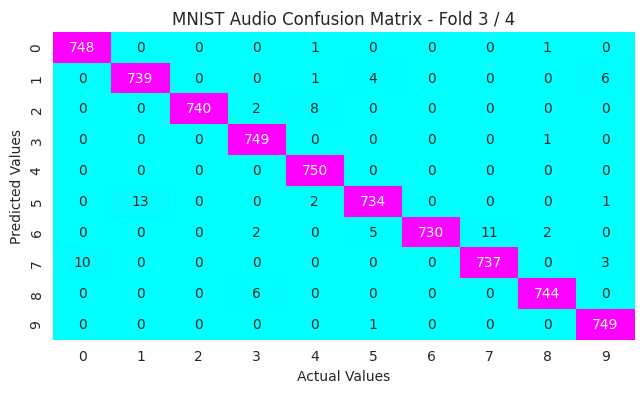

Beginning Fold 4 / 4
Epoch 1/25
704/704 [==============================] - 9s 9ms/step - loss: 0.2141 - accuracy: 0.9451 - val_loss: 0.0747 - val_accuracy: 0.9753
Epoch 2/25
704/704 [==============================] - 5s 7ms/step - loss: 0.0122 - accuracy: 0.9973 - val_loss: 0.0442 - val_accuracy: 0.9873
Epoch 3/25
704/704 [==============================] - 6s 9ms/step - loss: 0.0113 - accuracy: 0.9968 - val_loss: 0.0451 - val_accuracy: 0.9836
Epoch 4/25
704/704 [==============================] - 5s 8ms/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.0563 - val_accuracy: 0.9809
Epoch 5/25
704/704 [==============================] - 6s 9ms/step - loss: 0.0086 - accuracy: 0.9971 - val_loss: 0.0861 - val_accuracy: 0.9716
Epoch 6/25
704/704 [==============================] - 5s 8ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.0316 - val_accuracy: 0.9889
Epoch 7/25
704/704 [==============================] - 6s 8ms/step - loss: 0.0072 - accuracy: 0.9976 - val_loss: 0.0436 - val_ac

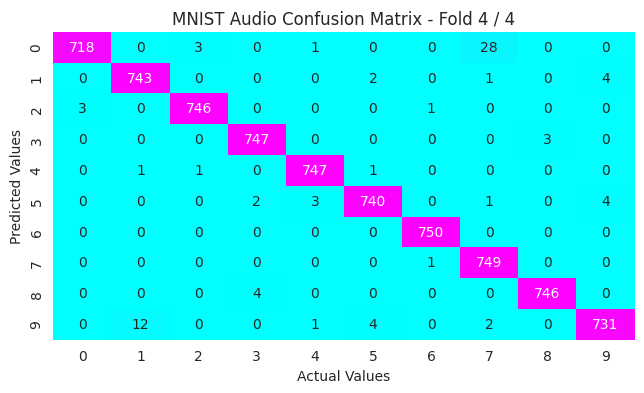

In [6]:
### Choose a fold index, split data, & process experiment
foldIndices = range(nFolds) # Will process all folds by default, or pick a subset, e.g. [0,1]

for foldIdx in foldIndices:
    print(f"Beginning Fold {foldIdx+1} / {nFolds}")
    trnData = pd.concat([mnist_byPersonId[ii] for ii in trnIds_byFold[foldIdx]])
    tstData = pd.concat([mnist_byPersonId[ii] for ii in tstIds_byFold[foldIdx]])

    # Convert to traditional np arrays [examples x 40(frequency-bins) x 40(time-frames) x 1(ch)]
    X_train = np.array(trnData['features'].to_list()); Y_train = np.array(trnData['class'].to_list())
    X_test = np.array(tstData['features'].to_list()); Y_test = np.array(tstData['class'].to_list())

    ## Normalize data (based on training data stats)
    medMean = np.median(np.mean(X_train[...,0], axis=(1,2)))
    medVar = np.median(np.var(X_train[...,0], axis=(1,2)))

    Xn_train = (X_train-medMean) / np.sqrt(medVar)
    Xn_test = (X_test-medMean) / np.sqrt(medVar)

    ### Instantiate the model, then train
    model = defineModel()
    cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
    # The callback will stop training early if no progress is being made, & restore best weights
    history = model.fit(Xn_train, Y_train, validation_data=(Xn_test,Y_test), batch_size=32, epochs=25, callbacks=cb)

    ### Evaluating trained model
    valLoss, valAcc = model.evaluate(Xn_test, Y_test, verbose=0)
    print(f"Fold {foldIdx+1}/{nFolds} Validation Accuracy: {100*valAcc:.2f}%")
    YPred_test = model.predict(Xn_test, verbose=0)

    seaborn.set_style('dark') # dark style needed to see confusion matrix numbers
    plt.figure(figsize=(7.5,4)); plt.title(f"MNIST Audio Confusion Matrix - Fold {foldIdx+1} / {nFolds}")
    cm = confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(YPred_test, axis=-1)) # Confusion matrix
    seaborn.heatmap(cm, annot=True, cmap="cool", fmt='g', cbar=False) # Plot confusion matrix as heatmap
    plt.xlabel("Actual Values"); plt.ylabel("Predicted Values"); plt.show()